<a href="https://colab.research.google.com/github/leejungp2/imdb-inflearn/blob/main/210115_nltk_install.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLTK 데이터 설치하기

In [ ]:
import nltk
!pip3 show nltk

Name: nltk
Version: 3.2.5
Summary: Natural Language Toolkit
Home-page: http://nltk.org/
Author: Steven Bird
Author-email: stevenbird1@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: six
Required-by: textblob


# 파트 1

NLP는?
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다.
이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Words) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.

In [ ]:
from google.colab import drive

In [ ]:
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

"""
header = 0은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""

# 레이블 sentiment가 있는 학습 데이터
train = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/imdb_data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

# 레이블이 없는 테스트 데이터
test = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/imdb_data/testData.tsv', header=0, delimiter='\t', quoting=3)

train.shape

(25000, 3)

In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
test.shape

(25000, 2)

In [ ]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [ ]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
# 레이블인 'sentiment'가 없다. 이 데이터를 기계학습을 통해 예측한다.
test.columns.values

array(['id', 'review'], dtype=object)

In [ ]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
import numpy as np
train.describe(exclude=[np.number])

,id,review
count,25000,25000
unique,25000,24904
top,"""10695_8""","""This show comes up with interesting locations..."
freq,1,3


In [ ]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [ ]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

1. BeautifulSoup(뷰티풀숩)을 통해 HTML 태그를 제거
2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
3. NLTK 데이터를 사용해 불용어(Stopword)를 제거
4. 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출


### 텍스트 데이터 전처리 이해하기

(출처 : [트위터 한국어 형태소 분석기](https://github.com/twitter/twitter-korean-text))
-> KoNLPy 사용

**정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)**

* 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

**토큰화 tokenization**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

**어근화 stemming (입니다 -> 이다)**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle


**어구 추출 phrase extraction**

* 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시

Introductory Presentation: [Google Slides](https://docs.google.com/presentation/d/10CZj8ry03oCk_Jqw879HFELzOLjJZ0EOi4KJbtRSIeU/)

+ 추가 개념 찾아보기
[정규 표현식](https://wikidocs.net/4308)

In [ ]:
!pip install BeautifulSoup4

In [ ]:
# 설치 및 버전확인
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.3
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: google, gdown, fastai, bs4


In [ ]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [ ]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌(^) 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [ ]:
# 모두 소문자로 변환한다.
lower_case = letters_only
# 문자를 나눈다 => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['With',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

불용어 제거(Stopword Removal)
일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

NLTK data 설치
http://corazzon.github.io/nltk_data_install

In [ ]:
import nltk
!pip3 show nltk
nltk.download('stopwords')

Name: nltk
Version: 3.2.5
Summary: Natural Language Toolkit
Home-page: http://nltk.org/
Author: Steven Bird
Author-email: stevenbird1@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: six
Required-by: textblob
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
# stopwords를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

231


['With',
 'stuff',
 'going',
 'moment',
 'MJ',
 'started',
 'listening',
 'music',
 'watching',
 'odd']

### 스테밍(어간추출, 형태소 분석)
출처 : [어간 추출 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)


* 어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
* "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
* stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다. [참고 : 모두의 데이터 과학 with 파이썬(길벗)](http://www.gilbut.co.kr/book/bookView.aspx?bookcode=BN001787)

In [ ]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of running is: {}".format(stemmer.stem("runs")))
print("The stemmed form of running is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of running is: run
The stemmed form of running is: run


In [ ]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of running is: {}".format(stemmer.stem("runs")))
print("The stemmed form of running is: {}".format(stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of running is: run
The stemmed form of running is: run


In [ ]:
# 처리 전 단어
words[:10]

['With',
 'stuff',
 'going',
 'moment',
 'MJ',
 'started',
 'listening',
 'music',
 'watching',
 'odd']

In [ ]:
# 스노우볼 스태머
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

# 처리 후 단어
words[:10]

['with',
 'stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd']

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다.
예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데
<pre>
1) *배*가 맛있다.
2) *배*를 타는 것이 재미있다.
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
</pre>
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. <br/>
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.
영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

* 참고 :
    - [Stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
    - [Lemmatisation - Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]

# 처리 후 단어
words[:10]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
fly
fly


['with',
 'stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd']

# 문자열 처리
위에서 간략하게 살펴본 내용을 바탕으로 문자열을 처리해 본다.

In [ ]:
# 전체 데이터 전처리 위해 함수로 만들어줌
def review_to_words( raw_review ):
  # 1. HTML 제거
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
  # 2. 영문자가 아닌 문자는 공백으로 변환
  letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
  # 3. 소문자 변환
  words = letters_only.lower().split()
  # 4. 파이썬에서는 리스트보다 세트로 찾는 게 훨씬 빠르다. stopwords를 세트로 변환한다.
  stops = set(stopwords.words('english'))
  # 5. stopwords 불용어 제거
  meaningful_words = [w for w in words if not w in stops]
  # 6. 어간추출
  stemming_words = [stemmer.stem(w) for w in meaningful_words]
  # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
  return(' '.join(stemming_words))

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [ ]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [ ]:
"""
clean_train_reviews = []
캐글 튜토리얼에는 range가 xrange로 되어있지만
여기에서는 python3를 사용하기 때문에 range를 사용했다.
"""
# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))
"""
하지만 위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
5000개 단위로 상태를 찍도록 개선했다.
"""
# clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1)%5000 == 0:
#         print('Review {} of {} '.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))

"""
그리고 코드를 좀 더 간결하게 하기 위해 for loop를 사용하는
대신 apply를 사용하도록 개선
"""
# %time train['review_clean'] = train['review'].apply(review_to_words)
"""
코드는 한 줄로 간결해 졌지만 여전히 오래 걸림
"""
# CPU times: user 1min 15s, sys: 2.3 s, total: 1min 18s
# Wall time: 1min 20s

# 필기: 위 방법을 사용할 경우 시간이 오래 걸리는 문제 발생
# 따라서 아래 방법 사용

In [ ]:
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
  df, func, kwargs = args
  return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
  # 키워드 항목 중 workers 파라미터를 꺼냄
  workers = kwargs.pop('workers')
  # 위에서 가져온 workers 수로 프로세스 풀을 정의
  pool = Pool(processes=workers)
  # 실행할 함수와 데이터프레임을 워커의 수만큼 나누어 작업
  result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
  pool.close()
  # 작업 결과를 합쳐서 반환
  return pd.concat(list(result))

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 473 ms, sys: 226 ms, total: 699 ms
Wall time: 1min 2s


In [ ]:
%time clean_test_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 486 ms, sys: 182 ms, total: 667 ms
Wall time: 1min 5s


### 워드 클라우드
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

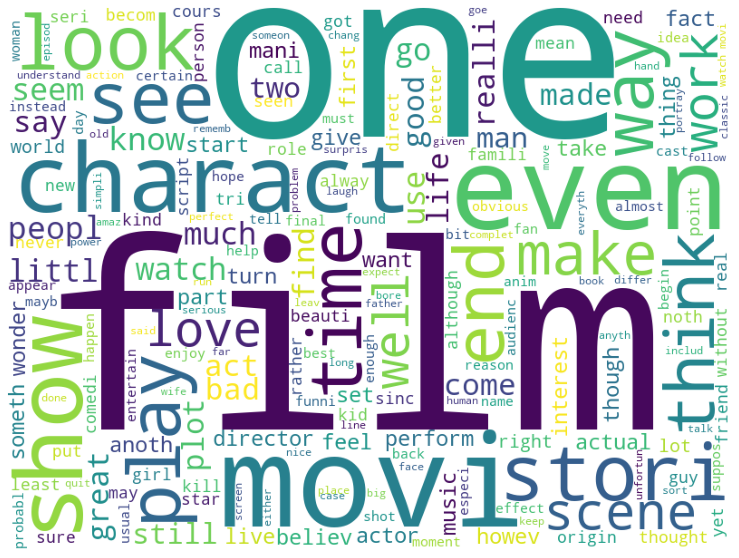

CPU times: user 23.7 s, sys: 1.24 s, total: 25 s
Wall time: 27.2 s


In [ ]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

In [ ]:
# 리뷰의 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

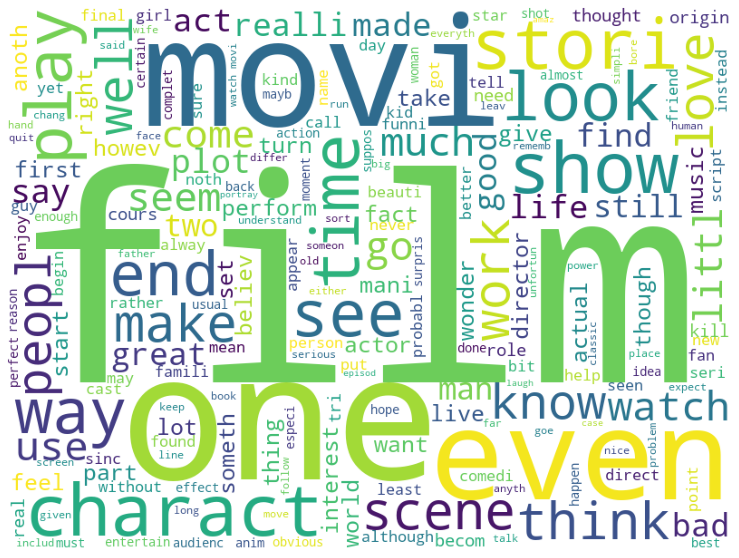

CPU times: user 22.8 s, sys: 779 ms, total: 23.5 s
Wall time: 24.9 s


In [ ]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

In [ ]:
# 첫 번째 리뷰에
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값: 119.52356
리뷰별 단어 중간 값 89.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


review unique word mean : 94.05756
review unique word median 74.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'review unique word distribution')

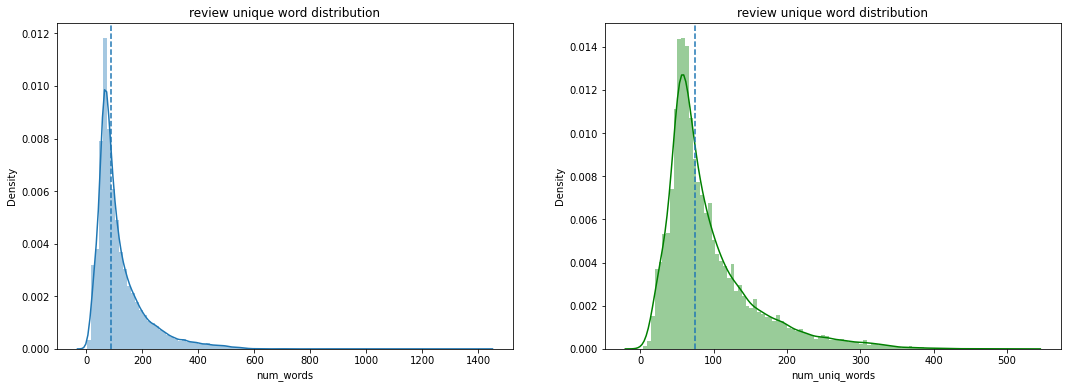

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(ncols = 2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값:', train['num_words'].mean())
print('리뷰별 단어 중간 값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('review unique word distribution')

print('review unique word mean :', train['num_uniq_words'].mean())
print('review unique word median', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('review unique word distribution')